# Tensor Fusion Model - CMU-MOSEI Dataset

In this notebook, we implement the Tensor Fusion Model, and test it on CMU-MOSEI dataset.

## Importing Libraries

In [1]:
import os
import sys
import torch
from torch import nn

import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.getcwd())
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

## Importing Helper Functions

In [2]:
from helpers.data.get_data import get_dataloader
from helpers.unimodals.common_models import GRUWithLinear, MLP
from helpers.fusions.common_fusions import Concat, TensorFusion
from helpers.training.all_in_one import all_in_one_train
from helpers.training.supervised_learning import train, test
from helpers.utils.common_utils import get_default_device, save_results

## Loading the Dataset

In [3]:
traindata, validdata, testdata = get_dataloader(
    '/scratch/rrm9598/data/mosei_senti_data.pkl', robust_test=False)

In [4]:
device = get_default_device()
print(device)

cuda


## Model Architecture

In [5]:
encoders = [GRUWithLinear(35, 64, 4, dropout=True, has_padding=True).to(device),
            GRUWithLinear(74, 128, 19, dropout=True, has_padding=True).to(device),
            GRUWithLinear(300, 512, 79, dropout=True, has_padding=True).to(device)]

head = MLP(8000, 512, 1).to(device)

fusion = TensorFusion().to(device)

## Training

In [6]:
FILE_NAME = 'mosei_tfus_r0'

In [7]:
train_losses, valid_losses = train(
    encoders, fusion, head, traindata, validdata, 30, 
    task="regression", optimtype=torch.optim.AdamW,
    early_stop=False, is_packed=True, lr=1e-3, 
    save=f'/scratch/rrm9598/Multimodal-Sentiment-Analysis/models/{FILE_NAME}.pt', 
    weight_decay=0.01, objective=torch.nn.L1Loss()
)

Epoch [1/30]
Train Loss: 0.7518
Valid Loss: 0.6441
Saving Best

Epoch [2/30]
Train Loss: 0.6491
Valid Loss: 0.6323
Saving Best

Epoch [3/30]
Train Loss: 0.6117
Valid Loss: 0.6185
Saving Best

Epoch [4/30]
Train Loss: 0.5775
Valid Loss: 0.6317

Epoch [5/30]
Train Loss: 0.5466
Valid Loss: 0.6121
Saving Best

Epoch [6/30]
Train Loss: 0.5014
Valid Loss: 0.6024
Saving Best

Epoch [7/30]
Train Loss: 0.4634
Valid Loss: 0.6220

Epoch [8/30]
Train Loss: 0.4246
Valid Loss: 0.6033

Epoch [9/30]
Train Loss: 0.3850
Valid Loss: 0.6173

Epoch [10/30]
Train Loss: 0.3507
Valid Loss: 0.6093

Epoch [11/30]
Train Loss: 0.3199
Valid Loss: 0.6052

Epoch [12/30]
Train Loss: 0.2956
Valid Loss: 0.6051

Epoch [13/30]
Train Loss: 0.2798
Valid Loss: 0.6084

Epoch [14/30]
Train Loss: 0.2592
Valid Loss: 0.6299

Epoch [15/30]
Train Loss: 0.2476
Valid Loss: 0.6188

Epoch [16/30]
Train Loss: 0.2388
Valid Loss: 0.6063

Epoch [17/30]
Train Loss: 0.2287
Valid Loss: 0.6165

Epoch [18/30]
Train Loss: 0.2217
Valid Loss: 0.6

Text(0.5, 1.0, 'Loss vs. No. of epochs')

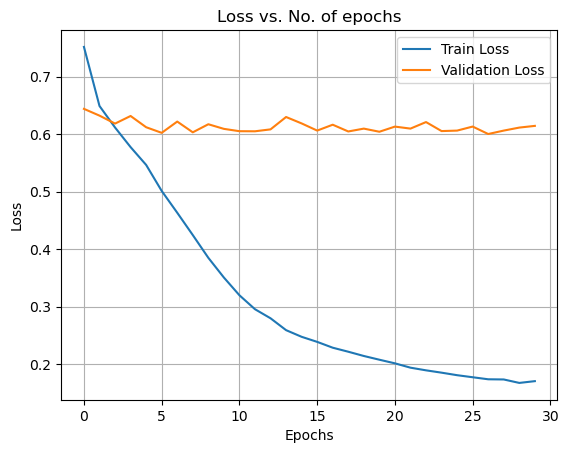

In [8]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss vs. No. of epochs')

In [9]:
save_results(train_losses, valid_losses, f'/scratch/rrm9598/Multimodal-Sentiment-Analysis/results/{FILE_NAME}.pkl')

## Testing

In [10]:
model = torch.load(f'/scratch/rrm9598/Multimodal-Sentiment-Analysis/models/{FILE_NAME}.pt').to(device)

test(model, test_dataloaders_all=testdata, dataset='mosi',
     is_packed=True, criterion=torch.nn.L1Loss(), task='posneg-classification', no_robust=True)

Recall: 80.6077% | Total Accuracy: 67.1118%
Inference Time: 2s184ms
Inference Params: 5488295
